In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import tqdm.notebook

import torchvision

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the SDE

A diffusion model is defined chiefly by its underpinning stochastic differential equation (SDE):

$dx = f(x, t)dt + g(x, t)d\omega$, where $f$ is the drift coefficient, and $g$ is the diffusion coefficient.

For any $x_{0}$ drawn from the original data distribution $p_{0}(x)$, running the SDE forward after time $t$ gives us a distribution of new objects, $p_{t}(x_{t}\vert x_{0})$.

In order to train and sample from a diffusion model, the SDE class needs to be implemented (in PyTorch). The SDE class must support the following methods:

1. `drift_coef_func(x, t)`: this defines $f(x, t)$
2. `diff_coef_func(x, t)`: this defines $g(x, t)$
3. `forward(x, t, return_score)`: the SDE defines (marginal) conditional probability transitions $p_{t}(x_{t}\vert x_{0})$, and this function runs the SDE forward by sampling noise $d\omega$; it may also return the score of conditional probability itself, $\nabla_{x}\log(p_{t}(x_{t}\vert x_{0}))$
4. `mean_score_mag(t)`: the expected magnitude (L2 norm) of the score $\nabla_{x}\log(p_{t}(x_{t}\vert x_{0}))$, normalized by the size of $x$
5. `sample_prior(t)`: this samples from the prior distribution $\pi(x)$ that the SDE converges to (may depend on $t$); this effectively samples from the conditional probability transitions, as $t\rightarrow\infty$

Theoretically, one needs only to subclass and implement an SDE object in order to change the underpinning SDE. However, training details may also need to be adjusted for better results. Additionally, we refactor all SDE-related definitions here for modularity, but because the outputs of these methods will be used and combined in different ways, it may not be most efficient to separate out these functions like this.

In [3]:
class SDE:
    
    # Base class for SDEs
    
    def __init__(self, input_shape, seed=None):
        """
        Arguments:
            `input_shape`: a tuple of ints which is the shape of input
                tensors x; does not include batch dimension
            `seed`: random seed for sampling and running the SDE
        """
        self.input_shape = input_shape
        self.rng = torch.Generator(device=DEVICE)
        if seed:
            self.rng.manual_seed(seed)
            
            
    def _inflate_dims(self, v):
        """
        Given a tensor vector `v`, appends dimensions of size 1 so that
        it has the same number of dimensions as `self.input_shape`. For
        example, if `self.input_shape` is (3, 50, 50), then this function
        turns `v` from a B-tensor to a B x 1 x 1 x 1 tensor. This is
        useful for combining the tensor with things shaped like the input
        later.
        Arguments:
            `v`: a B-tensor
        Returns a B x `self.input_shape` tensor.
        """
        return v[(slice(None),) + ((None,) * len(self.input_shape))]

    
    def drift_coef_func(self, xt, t):
        """
        Definition of drift coefficient f(xt, t).
        Arguments:
            `xt`: a B x `self.input_shape` tensor containing the data at
                some time points
            `t`: a B-tensor containing the time in the SDE for each input
        Returns a B x `self.input_shape` tensor.
        """
        return torch.zeros_like(xt)
    
    
    def diff_coef_func(self, xt, t):
        """
        Definition of diffusion coefficient g(t).
        Arguments:
            `xt`: a B x `self.input_shape` tensor containing the data at
                some time points
            `t`: a B-tensor containing the time in the SDE
        Returns a B x `self.input_shape` tensor.
        """
        return torch.zeros_like(xt)
    
    
    def forward(self, x0, t, return_score=True):
        """
        Runs the SDE forward given starting point `x0` and a time `t`.
        Optional returns the score: the gradient (with respect to x) of the
        log conditional probability, pt(xt | x0).
        Arguments:
            `x0`: a B x `self.input_shape` tensor containing the data at
                some time points
            `t`: a B-tensor containing the time in the SDE for each input
        Returns a B x `self.input_shape` tensor to represent xt. If
        `return_score` is True, then also returns a B x `self.input_shape`
        tensor which is the gradient of the log conditional probability
        (with respect to `xt`).
        """
        if return_score:
            return torch.zeros_like(x0), torch.zeros_like(x0)
        else:
            return torch.zeros_like(x0)
        
        
    def mean_score_mag(self, t):
        """
        Returns the average magnitude (squared L2 norm) of the score
        (averaged over sampling and data distribution), divided by the
        size of `x`. That is, this should be ||score||_2^2 / d, where d
        is the size of `x`.
        Arguments:
            `t`: a B-tensor containing the time in the SDE
        Returns a B-tensor containing the expected magnitude of the score
        function at each time `t`.
        """
        return torch.ones_like(t)
        
        
    def sample_prior(self, num_samples, t):
        """
        Samples from the prior distribution specified by the SDE at time `t`.
        Arguments:
            `num_samples`: B, the number of samples to return
            `t`: a B-tensor containing the times in the SDE to sample for
        Returns a B x `self.input_shape` tensor for the `xt` values that
        are sampled.
        """
        return torch.zeros(torch.Size([num_samples] + list(self.input_shape)))
    
    
    def __str__(self):
        return "Base SDE"

#### Variance-exploding SDE

Let us define our SDE to be the following:

$dx = \sigma^{t}d\omega$

That is, $f(x, t) = 0$ and $g(t) = \sigma^{t}$

In this case, our conditional probability is $p_{t}(x_{t}\vert x_{0}) = Norm(x_{0}, \frac{\sigma^{2t} - 1}{2\log(\sigma)}I)$.

That is, $x_{t} = x_{0} + \sqrt{\frac{\sigma^{2t} - 1}{2\log(\sigma)}}z$ for $z \sim Norm(0, I)$.

Our conditional probability *score* is $\nabla_{x}\log(p_{t}(x_{t}\vert x_{0})) = -\frac{z}{\sqrt{\frac{\sigma^{2t} - 1}{2\log(\sigma)}}}$

The expected magnitude of $\Vert \nabla_{x}\log(p_{t}(x_{t}\vert x_{0}))\Vert_{2}^{2}$ is $\frac{d}{\frac{\sigma^{2t} - 1}{2\log(\sigma)}}$, if $x \in \mathbb{R}^{d}$

In [4]:
class VarianceExplodingSDE(SDE):
    
    def __init__(self, sigma, input_shape, seed=None):
        """
        Arguments:
            `sigma`: the sigma in dx = sigma^t dw
            `input_shape`: a tuple of ints which is the shape of input
                tensors x; does not include batch dimension
            `seed`: random seed for sampling and running the SDE
        """
        super().__init__(input_shape, seed)
        
        self.sigma = torch.tensor(sigma).to(DEVICE)
        self.string = "Variance Exploding SDE (beta(t) = %.2f^t)" % sigma
    
    
    def drift_coef_func(self, xt, t):
        """
        Definition of drift coefficient f(xt, t).
        Arguments:
            `xt`: a B x `self.input_shape` tensor containing the data at
                some time points
            `t`: a B-tensor containing the time in the SDE for each input
        Returns a B x `self.input_shape` tensor.
        """
        return torch.zeros_like(xt)
    
    
    def diff_coef_func(self, xt, t):
        """
        Definition of diffusion coefficient g(t).
        Arguments:
            `xt`: a B x `self.input_shape` tensor containing the data at
                some time points
            `t`: a B-tensor containing the time in the SDE
        Returns a B x `self.input_shape` tensor.
        """
        return self._inflate_dims(torch.pow(self.sigma, t))
    
    
    def forward(self, x0, t, return_score=True):
        """
        Runs the SDE forward given starting point `x0` and a time `t`.
        Optional returns the score: the gradient (with respect to x) of the
        log conditional probability, pt(xt | x0).
        Arguments:
            `xt`: a B x `self.input_shape` tensor containing the data at
                some time points
            `t`: a B-tensor containing the time in the SDE for each input
        Returns a B x `self.input_shape` tensor to represent xt. If
        `return_score` is True, then also returns a B x `self.input_shape`
        tensor which is the gradient of the log conditional probability
        (with respect to `xt`).
        """
        z = torch.normal(
            torch.zeros_like(x0), torch.ones_like(x0), generator=self.rng
        )  # Shape: B x ...
        
        variance = (torch.pow(self.sigma, 2 * t) - 1) / (2 * torch.log(self.sigma))
        std = self._inflate_dims(torch.sqrt(variance))  # Shape: B x ...        
        xt = x0 + (std * z)
        
        if return_score:
            score = -z / std
            return xt, score
        else:
            return xt
        

    def mean_score_mag(self, t):
        """
        Returns the average magnitude (squared L2 norm) of the score
        (averaged over sampling and data distribution), divided by the
        size of `x`. That is, this should be ||score||_2^2 / d, where d
        is the size of `x`.
        Arguments:
            `t`: a B-tensor containing the time in the SDE
        Returns a B-tensor containing the expected magnitude of the score
        function at each time `t`, divided by the size of `x`.
        """
        variance = (torch.pow(self.sigma, 2 * t) - 1) / (2 * torch.log(self.sigma))
        return 1 / variance  # Shape: B
        
        
    def sample_prior(self, num_samples, t):
        """
        Samples from the prior distribution specified by the SDE at time `t`.
        Arguments:
            `num_samples`: B, the number of samples to return
            `t`: a B-tensor containing the times in the SDE to sample for
        Returns a B x `self.input_shape` tensor for the `xt` values that
        are sampled.
        """
        shape = torch.Size([num_samples]) + torch.Size(self.input_shape)
        z = torch.normal(
            torch.zeros(shape).to(DEVICE), torch.ones(shape).to(DEVICE), generator=self.rng
        )  # Shape: B x ...
        
        variance = (torch.pow(self.sigma, 2 * t) - 1) / (2 * torch.log(self.sigma))
        std = self._inflate_dims(torch.sqrt(variance))  # Shape: B x ...
        
        return z * std
    
    
    def __str__(self):
        return self.string

#### Variance-preserving SDE

Let us define our SDE to be the following:

$dx = -\frac{1}{2}\beta(t)xdt + \sqrt{\beta(t)}d\omega$

That is, $f(x, t) = -\frac{1}{2}\beta(t)x$ and $g(t) = \sqrt{\beta(t)}$

For simplicity, let us have $\beta(t) = \beta_{0} + \Delta\beta t$, where $\Delta\beta = \beta_{1}-\beta_{0}$

We define $\overline{\beta_{t}} = \int\limits_{0}^{t}\beta(s)ds = \beta_{0}t + \frac{1}{2}\Delta\beta t^{2}$

In this case, our conditional probability is $p_{t}(x_{t}\vert x_{0}) = Norm(x(0)\exp(-\frac{1}{2}\overline{\beta_{t}}), (1 - \exp(-\overline{\beta_{t}}))I)$

That is, $x_{t} = x_{0}\exp(-\frac{1}{2}\overline{\beta_{t}}) + \sqrt{1 - \exp(-\overline{\beta_{t}})}z$ for $z \sim Norm(0, I)$.

Our conditional probability *score* is $\nabla_{x}\log(p_{t}(x_{t}\vert x_{0})) = -\frac{z}{\sqrt{1 - \exp(-\overline{\beta_{t}})}}$

The expected magnitude of $\Vert \nabla_{x}\log(p_{t}(x_{t}\vert x_{0}))\Vert_{2}^{2}$ is $\frac{d}{1 - \exp(-\overline{\beta_{t}})}$, if $x \in \mathbb{R}^{d}$

In [5]:
class VariancePreservingSDE(SDE):
    
    def __init__(self, beta_0, beta_1, input_shape, seed=None):
        """
        Arguments:
            `beta_0`: beta(0); see below
            `beta_1`: beta(1); beta(t) will be linearly interpolated
                between beta(0) and beta(1)
            `input_shape`: a tuple of ints which is the shape of input
                tensors x; does not include batch dimension
            `seed`: random seed for sampling and running the SDE
        """
        super().__init__(input_shape, seed)
        
        self.beta_0 = torch.tensor(beta_0).to(DEVICE)
        self.delta_beta = torch.tensor(beta_1 - beta_0).to(DEVICE)
        self.string = "Variance Preserving SDE (beta(t) = %.2f + %.2ft)" % (beta_0, beta_1 - beta_0)
        
    def _beta(self, t):
        """
        Computes beta(t).
        Arguments:
            `t`: a B-tensor of times
        Returns a B-tensor of beta values.
        """
        return self.beta_0 + (self.delta_beta * t)
        
        
    def _beta_bar(self, t):
        """
        Computes the integral of beta(0) to beta(t).
        Arguments:
            `t`: a B-tensor of times
        Returns a B-tensor of beta-bar values.
        """
        return (self.beta_0 * t) + (0.5 * self.delta_beta * torch.square(t))
        
    
    def drift_coef_func(self, xt, t):
        """
        Definition of drift coefficient f(xt, t).
        Arguments:
            `xt`: a B x `self.input_shape` tensor containing the data at
                some time points
            `t`: a B-tensor containing the time in the SDE for each input
        Returns a B x `self.input_shape` tensor.
        """
        return -0.5 * self._inflate_dims(self._beta(t)) * xt
    
    
    def diff_coef_func(self, xt, t):
        """
        Definition of diffusion coefficient g(t).
        Arguments:
            `xt`: a B x `self.input_shape` tensor containing the data at
                some time points
            `t`: a B-tensor containing the time in the SDE
        Returns a B x `self.input_shape` tensor.
        """
        return self._inflate_dims(torch.sqrt(self._beta(t)))
    
    
    def forward(self, x0, t, return_score=True):
        """
        Runs the SDE forward given starting point `x0` and a time `t`.
        Optional returns the score: the gradient (with respect to x) of the
        log conditional probability, pt(xt | x0).
        Arguments:
            `xt`: a B x `self.input_shape` tensor containing the data at
                some time points
            `t`: a B-tensor containing the time in the SDE for each input
        Returns a B x `self.input_shape` tensor to represent xt. If
        `return_score` is True, then also returns a B x `self.input_shape`
        tensor which is the gradient of the log conditional probability
        (with respect to `xt`).
        """
        z = torch.normal(
            torch.zeros_like(x0), torch.ones_like(x0), generator=self.rng
        )  # Shape: B x ...
        
        mean = x0 * torch.exp(-0.5 * self._inflate_dims(self._beta_bar(t)))
        variance = 1 - torch.exp(-self._beta_bar(t))
        std = self._inflate_dims(torch.sqrt(variance))  # Shape: B x ...
        
        xt = mean + (std * z)
        
        if return_score:
            score = -z / std
            return xt, score
        else:
            return xt
        

    def mean_score_mag(self, t):
        """
        Returns the average magnitude (squared L2 norm) of the score
        (averaged over sampling and data distribution), divided by the
        size of `x`. That is, this should be ||score||_2^2 / d, where d
        is the size of `x`.
        Arguments:
            `t`: a B-tensor containing the time in the SDE
        Returns a B-tensor containing the expected magnitude of the score
        function at each time `t`.
        """
        variance = 1 - torch.exp(-self._beta_bar(t))
        return 1 / variance  # Shape: B
        
        
    def sample_prior(self, num_samples, t):
        """
        Samples from the prior distribution specified by the SDE at time `t`.
        Arguments:
            `num_samples`: B, the number of samples to return
            `t`: a B-tensor containing the times in the SDE to sample for
        Returns a B x `self.input_shape` tensor for the `xt` values that
        are sampled.
        """
        # We will sample in the limit as t approaches infinity
        shape = torch.Size([num_samples]) + torch.Size(self.input_shape)
        return torch.normal(
            torch.zeros(shape).to(DEVICE), torch.ones(shape).to(DEVICE), generator=self.rng
        )  # Shape: B x ...
    
    
    def __str__(self):
        return self.string

#### Hongler SDE

Let us define our SDE to be the following:

$dx = -\frac{1}{2}\tanh(x)(\mu^{2}\text{sech}^{2}(x) + 2)\beta(t)dt + \mu\text{sech}(x)\sqrt{\beta(t)}d\omega$

That is, $f(x, t) = -\frac{1}{2}\tanh(x)(\mu^{2}\text{sech}^{2}(x) + 2)\beta(t)$ and $g(t) = \mu\text{sech}(x)\sqrt{\beta(t)}$

Let us have $\beta(t) = (\frac{t}{a})^{b}$, parameterized by $a$ (the length of time for variance to grow slowly) and $b$ (the steepness of variance growth)

We define $\overline{\beta_{t}} = \int\limits_{0}^{t}\beta(s)ds$

$\mu$ is a parameter which determines the prior distribution the SDE converges to. If $\mu < \sqrt{2}$, the prior is unimodal and Gaussian-like. If $\mu = \sqrt{2}$, it has a somewhat flat singular mode. If $\mu > \sqrt{2}$, the prior is bimodal, and the modes extremify for larger $\mu$.

In particular, the prior is $\pi(x) = \frac{cosh(x)}{\sqrt{\pi}\mu}\exp(-\frac{\sinh^{2}(x)}{\mu^{2}})$

In this case, our conditional probability is $p_{t}(x_{t}\vert x_{0}) = \sinh^{-1}(y_{t})$, where $y_{t} = Norm(y_{0}\exp(-\overline{\beta_{t}}), (\frac{1}{2}\mu^{2}(1-\exp(-2\overline{\beta_{t}})))I)$, and $y_{0} = \sinh(x_{0})$

That is, $x_{t} = \sinh^{-1}(\sinh(x_{0})\exp(-\overline{\beta_{t}}) + \mu\sqrt{\frac{1-\exp(-2\overline{\beta_{t}})}{2}}z)$ for $z \sim Norm(0, I)$.

Our conditional probability *score* is $\nabla_{x}\log(p_{t}(x_{t}\vert x_{0})) = \frac{\cosh(x_{t})}{\mu^{2}}A + \tanh(x_{t})$, where $A = \sinh(x_{0})\text{csch}(\overline{\beta_{t}})- \sinh(x_{t})(\text{coth}(\overline{\beta_{t}}) + 1)$

The expected magnitude of $\Vert \nabla_{x}\log(p_{t}(x_{t}\vert x_{0}))\Vert_{2}^{2}$ is ???

In [6]:
class HonglerSDE(SDE):
    
    def __init__(self, mu, a, b, input_shape, seed=None):
        """
        Arguments:
            `mu`: mu parameter of the SDE, which determines the shape
                of the prior
            `a`: length of time for the slow-growing variance regime
            `b`: steepness of variance growth
            `input_shape`: a tuple of ints which is the shape of input
                tensors x; does not include batch dimension
            `seed`: random seed for sampling and running the SDE
        """
        super().__init__(input_shape, seed)
        
        self.mu = torch.tensor(mu).to(DEVICE)
        self.a = torch.tensor(a).to(DEVICE)
        self.b = torch.tensor(b).to(DEVICE)
        self.string = "Hongler SDE (mu = %.2f, beta(t) = (t / %.2f)^%.2f)" % (mu, a, b)
        
        
    def _beta(self, t):
        """
        Computes beta(t).
        Arguments:
            `t`: a B-tensor of times
        Returns a B-tensor of beta values.
        """
        return torch.pow(t / self.a, self.b)
        
        
    def _beta_bar(self, t):
        """
        Computes the integral of beta(0) to beta(t).
        Arguments:
            `t`: a B-tensor of times
        Returns a B-tensor of beta-bar values.
        """
        return (self.a / (self.b + 1)) * torch.pow(t / self.a, self.b + 1)
        
    
    def drift_coef_func(self, xt, t):
        """
        Definition of drift coefficient f(xt, t).
        Arguments:
            `xt`: a B x `self.input_shape` tensor containing the data at
                some time points
            `t`: a B-tensor containing the time in the SDE for each input
        Returns a B x `self.input_shape` tensor.
        """
        beta = self._inflate_dims(self._beta(t))
        return -0.5 * torch.tanh(xt) * ((torch.square(self.mu) * torch.square(1 / torch.cosh(xt))) + 2) * beta
    
    
    def diff_coef_func(self, xt, t):
        """
        Definition of diffusion coefficient g(t).
        Arguments:
            `xt`: a B x `self.input_shape` tensor containing the data at
                some time points
            `t`: a B-tensor containing the time in the SDE
        Returns a B x `self.input_shape` tensor.
        """
        beta = self._inflate_dims(self._beta(t))
        return self.mu * torch.sqrt(beta) / torch.cosh(xt)
    
    
    def forward(self, x0, t, return_score=True):
        """
        Runs the SDE forward given starting point `x0` and a time `t`.
        Optional returns the score: the gradient (with respect to x) of the
        log conditional probability, pt(xt | x0).
        Arguments:
            `xt`: a B x `self.input_shape` tensor containing the data at
                some time points
            `t`: a B-tensor containing the time in the SDE for each input
        Returns a B x `self.input_shape` tensor to represent xt. If
        `return_score` is True, then also returns a B x `self.input_shape`
        tensor which is the gradient of the log conditional probability
        (with respect to `xt`).
        """
        # Sample xt
        z = torch.normal(
            torch.zeros_like(x0), torch.ones_like(x0), generator=self.rng
        )  # Shape: B x ...
        beta_bar = self._inflate_dims(self._beta_bar(t))
        mean = torch.exp(-beta_bar)
        std = self.mu * torch.sqrt((1 - torch.exp(-2 * beta_bar)) / 2)
        xt = torch.arcsinh((torch.sinh(x0) * mean) + (std * z))
        
        if return_score:
            a = (torch.sinh(x0) * (1 / torch.sinh(beta_bar))) - (torch.sinh(xt) * ((1 / torch.tanh(beta_bar)) + 1))
            score = (a * torch.cosh(xt) / torch.square(self.mu)) + torch.tanh(xt)
            return xt, score
        else:
            return xt
        

    def mean_score_mag(self, t):
        """
        Returns the average magnitude (squared L2 norm) of the score
        (averaged over sampling and data distribution), divided by the
        size of `x`. That is, this should be ||score||_2^2 / d, where d
        is the size of `x`.
        Arguments:
            `t`: a B-tensor containing the time in the SDE
        Returns a B-tensor containing the expected magnitude of the score
        function at each time `t`.
        """
        raise NotImplementedError
        
        
    def sample_prior(self, num_samples, t):
        """
        Samples from the prior distribution specified by the SDE at time `t`.
        Arguments:
            `num_samples`: B, the number of samples to return
            `t`: a B-tensor containing the times in the SDE to sample for
        Returns a B x `self.input_shape` tensor for the `xt` values that
        are sampled.
        """
        # We will sample in the limit as t approaches infinity
        shape = torch.Size([num_samples]) + torch.Size(self.input_shape)
        z = torch.normal(
            torch.zeros(shape).to(DEVICE), torch.ones(shape).to(DEVICE), generator=self.rng
        )  # Shape: B x ...
        return torch.arcsinh((self.mu / torch.sqrt(torch.tensor(2)).to(DEVICE)) * z)
    
    
    def __str__(self):
        return self.string

### Define the score model $s_{\theta}$

We will start by defining it for image data, using a U-net architecture.

In [7]:
class ScoreUNet(torch.nn.Module):

    def __init__(
        self, channels=[32, 64, 128, 256], time_embed_size=256, mean_score_mag=None,
        data_channels=1
    ):
        """
        Initialize a time-dependent score-based U-net.
        Arguments:
            `channels`: the number of channels in each "layer" of the U-net
            `time_embed_size`: size of the time embeddings
            `mean_score_mag`: if given, rescales the model outputs by multiplying
                by the average score magnitude (L2 norm); this must be a function
                which takes in a B-tensor of time points, and returns a B-tensor
                of expected squared L2 norms
            `data_channels`: number of channels in input image
        Note this architecture assumes the initial depth of the images is 1.
        """
        super().__init__()
        
        self.mean_score_mag = mean_score_mag
        
        # Random embedding layer for time; the random weights are set at the
        # start and are not trainable
        self.time_embed_rand_weights = torch.nn.Parameter(
            torch.randn(time_embed_size // 2) * 30, requires_grad=False
        )
        self.time_embed_dense = torch.nn.Linear(time_embed_size, time_embed_size)
        
        # Encoders: receptive field increases and depth increases
        self.conv_e1 = torch.nn.Conv2d(data_channels, channels[0], kernel_size=3, stride=1, bias=False)
        self.time_dense_e1 = torch.nn.Linear(time_embed_size, channels[0])
        self.norm_e1 = torch.nn.GroupNorm(4, num_channels=channels[0])
        
        self.conv_e2 = torch.nn.Conv2d(channels[0], channels[1], kernel_size=3, stride=2, bias=False)
        self.time_dense_e2 = torch.nn.Linear(time_embed_size, channels[1])
        self.norm_e2 = torch.nn.GroupNorm(32, num_channels=channels[1])
        
        self.conv_e3 = torch.nn.Conv2d(channels[1], channels[2], kernel_size=3, stride=2, bias=False)
        self.time_dense_e3 = torch.nn.Linear(time_embed_size, channels[2])
        self.norm_e3 = torch.nn.GroupNorm(32, num_channels=channels[2])
        
        self.conv_e4 = torch.nn.Conv2d(channels[2], channels[3], kernel_size=3, stride=2, bias=False)
        self.time_dense_e4 = torch.nn.Linear(time_embed_size, channels[3])
        self.norm_e4 = torch.nn.GroupNorm(32, num_channels=channels[3])   

        # Decoders: depth decreases
        self.conv_d4 = torch.nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.time_dense_d4 = torch.nn.Linear(time_embed_size, channels[2])
        self.norm_d4 = torch.nn.GroupNorm(32, num_channels=channels[2])
        
        self.conv_d3 = torch.nn.ConvTranspose2d(channels[2] * 2, channels[1], 3, stride=2, output_padding=1, bias=False)
        self.time_dense_d3 = torch.nn.Linear(time_embed_size, channels[1])
        self.norm_d3 = torch.nn.GroupNorm(32, num_channels=channels[1])
        
        self.conv_d2 = torch.nn.ConvTranspose2d(channels[1] * 2, channels[0], 3, stride=2, output_padding=1, bias=False)
        self.time_dense_d2 = torch.nn.Linear(time_embed_size, channels[0])
        self.norm_d2 = torch.nn.GroupNorm(32, num_channels=channels[0])
        
        self.conv_d1 = torch.nn.ConvTranspose2d(channels[0] * 2, data_channels, 3, stride=1, bias=True)

        # Activation functions
        self.swish = lambda x: x * torch.sigmoid(x)  # Swish activation: x * sigmoid(x)

        
    def forward(self, xt, t):
        """
        Forward pass of the network.
        Arguments:
            `xt`: B x 1 x H x W tensor containing the images to train on
            `t`: B-tensor containing the times to train the network for each
                image
        Returns a B x 1 x H x W tensor which consists of the (unnormalized)
        score estimate.
        """
        # Get the time embeddings for `t`
        # We first sample vector z from some zero-mean Gaussian (of fixed variance),
        # and then we embed the time as cos(2 * pi * t * z) and sin(2 * pi * t * z)
        time_embed_args = t[:, None] * self.time_embed_rand_weights[None, :] * 2 * np.pi
        # Shape: B x (E / 2)
        time_embed = self.swish(
            torch.cat([torch.sin(time_embed_args), torch.cos(time_embed_args)], dim=1)
        )
        # Shape: B x E
        
        # Encoding
        enc_1_out = self.swish(self.norm_e1(
            self.conv_e1(xt) + self.time_dense_e1(time_embed)[:, :, None, None]
        ))
        enc_2_out = self.swish(self.norm_e2(
            self.conv_e2(enc_1_out) + self.time_dense_e2(time_embed)[:, :, None, None]
        ))
        enc_3_out = self.swish(self.norm_e3(
            self.conv_e3(enc_2_out) + self.time_dense_e3(time_embed)[:, :, None, None]
        ))
        enc_4_out = self.swish(self.norm_e4(
            self.conv_e4(enc_3_out) + self.time_dense_e4(time_embed)[:, :, None, None]
        ))
            
        # Decoding
        dec_4_out = self.swish(self.norm_d4(
            self.conv_d4(enc_4_out) + self.time_dense_d4(time_embed)[:, :, None, None]
        ))
        dec_3_out = self.swish(self.norm_d3(
            self.conv_d3(torch.cat([dec_4_out, enc_3_out], dim=1)) + self.time_dense_d3(time_embed)[:, :, None, None]
        ))
        dec_2_out = self.swish(self.norm_d2(
            self.conv_d2(torch.cat([dec_3_out, enc_2_out], dim=1)) + self.time_dense_d2(time_embed)[:, :, None, None]
        ))
        dec_1_out = self.conv_d1(torch.cat([dec_2_out, enc_1_out], dim=1))
        
        if self.mean_score_mag:
            pred = dec_1_out * torch.sqrt(self.mean_score_mag(t)[:, None, None, None])
        else:
            pred = dec_1_out
        
        return pred

In [8]:
# class ScoreUNet(torch.nn.Module):

#     def __init__(
#         self, channels=[32, 64, 128, 256], time_embed_size=256, mean_score_mag=None,
#         data_channels=1
#     ):
#         """
#         Initialize a time-dependent score-based U-net.
#         Arguments:
#             `channels`: the number of channels in each "layer" of the U-net
#             `time_embed_size`: size of the time embeddings
#             `mean_score_mag`: if given, rescales the model outputs by multiplying
#                 by the average score magnitude (L2 norm); this must be a function
#                 which takes in a B-tensor of time points, and returns a B-tensor
#                 of expected squared L2 norms
#             `data_channels`: number of channels in input image
#         Note this architecture assumes the initial depth of the images is 1.
#         """
#         super().__init__()
        
#         self.mean_score_mag = mean_score_mag
        
#         # Random embedding layer for time; the random weights are set at the
#         # start and are not trainable
#         self.time_embed_rand_weights = torch.nn.Parameter(
#             torch.randn(time_embed_size // 2) * 30, requires_grad=False
#         )
#         self.time_embed_dense = torch.nn.Linear(time_embed_size, time_embed_size)
        
#         # Encoders: receptive field increases and depth increases
#         self.conv_e1 = torch.nn.Conv2d(data_channels, channels[0], kernel_size=5, stride=1, bias=False)
#         self.time_dense_e1 = torch.nn.Linear(time_embed_size, channels[0])
#         self.norm_e1 = torch.nn.GroupNorm(4, num_channels=channels[0])
        
#         self.conv_e2 = torch.nn.Conv2d(channels[0], channels[1], kernel_size=5, stride=2, bias=False)
#         self.time_dense_e2 = torch.nn.Linear(time_embed_size, channels[1])
#         self.norm_e2 = torch.nn.GroupNorm(32, num_channels=channels[1])
        
#         self.conv_e3 = torch.nn.Conv2d(channels[1], channels[2], kernel_size=3, stride=2, bias=False)
#         self.time_dense_e3 = torch.nn.Linear(time_embed_size, channels[2])
#         self.norm_e3 = torch.nn.GroupNorm(32, num_channels=channels[2])
        
#         self.conv_e4 = torch.nn.Conv2d(channels[2], channels[3], kernel_size=3, stride=2, bias=False)
#         self.time_dense_e4 = torch.nn.Linear(time_embed_size, channels[3])
#         self.norm_e4 = torch.nn.GroupNorm(32, num_channels=channels[3])   

#         # Decoders: depth decreases
#         self.conv_d4 = torch.nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, output_padding=0, bias=False)
#         self.time_dense_d4 = torch.nn.Linear(time_embed_size, channels[2])
#         self.norm_d4 = torch.nn.GroupNorm(32, num_channels=channels[2])
        
#         self.conv_d3 = torch.nn.ConvTranspose2d(channels[2] * 2, channels[1], 3, stride=2, output_padding=1, bias=False)
#         self.time_dense_d3 = torch.nn.Linear(time_embed_size, channels[1])
#         self.norm_d3 = torch.nn.GroupNorm(32, num_channels=channels[1])
        
#         self.conv_d2 = torch.nn.ConvTranspose2d(channels[1] * 2, channels[0], 5, stride=2, output_padding=1, bias=False)
#         self.time_dense_d2 = torch.nn.Linear(time_embed_size, channels[0])
#         self.norm_d2 = torch.nn.GroupNorm(32, num_channels=channels[0])
        
#         self.conv_d1 = torch.nn.ConvTranspose2d(channels[0] * 2, data_channels, 5, stride=1, bias=True)

#         # Activation functions
#         self.swish = lambda x: x * torch.sigmoid(x)  # Swish activation: x * sigmoid(x)

        
#     def forward(self, xt, t):
#         """
#         Forward pass of the network.
#         Arguments:
#             `xt`: B x 1 x H x W tensor containing the images to train on
#             `t`: B-tensor containing the times to train the network for each
#                 image
#         Returns a B x 1 x H x W tensor which consists of the (unnormalized)
#         score estimate.
#         """
#         # Get the time embeddings for `t`
#         # We first sample vector z from some zero-mean Gaussian (of fixed variance),
#         # and then we embed the time as cos(2 * pi * t * z) and sin(2 * pi * t * z)
#         time_embed_args = t[:, None] * self.time_embed_rand_weights[None, :] * 2 * np.pi
#         # Shape: B x (E / 2)
#         time_embed = self.swish(
#             torch.cat([torch.sin(time_embed_args), torch.cos(time_embed_args)], dim=1)
#         )
#         # Shape: B x E
        
#         # Encoding
#         enc_1_out = self.swish(self.norm_e1(
#             self.conv_e1(xt) + self.time_dense_e1(time_embed)[:, :, None, None]
#         ))
#         enc_2_out = self.swish(self.norm_e2(
#             self.conv_e2(enc_1_out) + self.time_dense_e2(time_embed)[:, :, None, None]
#         ))
#         enc_3_out = self.swish(self.norm_e3(
#             self.conv_e3(enc_2_out) + self.time_dense_e3(time_embed)[:, :, None, None]
#         ))
#         enc_4_out = self.swish(self.norm_e4(
#             self.conv_e4(enc_3_out) + self.time_dense_e4(time_embed)[:, :, None, None]
#         ))
            
#         # Decoding
#         dec_4_out = self.swish(self.norm_d4(
#             self.conv_d4(enc_4_out) + self.time_dense_d4(time_embed)[:, :, None, None]
#         ))
#         dec_3_out = self.swish(self.norm_d3(
#             self.conv_d3(torch.cat([dec_4_out, enc_3_out], dim=1)) + self.time_dense_d3(time_embed)[:, :, None, None]
#         ))
#         dec_2_out = self.swish(self.norm_d2(
#             self.conv_d2(torch.cat([dec_3_out, enc_2_out], dim=1)) + self.time_dense_d2(time_embed)[:, :, None, None]
#         ))
#         dec_1_out = self.conv_d1(torch.cat([dec_2_out, enc_1_out], dim=1))
        
#         if self.mean_score_mag:
#             pred = dec_1_out * torch.sqrt(self.mean_score_mag(t)[:, None, None, None])
#         else:
#             pred = dec_1_out
        
#         return pred

### Create the dataloader

In [9]:
image_to_tensor = torchvision.transforms.ToTensor()
dataset = torchvision.datasets.MNIST(
    '/gstore/data/resbioai/tsenga5/', train=True, transform=(lambda img: (image_to_tensor(img) * 2) - 1)
)
# dataset = torchvision.datasets.ImageFolder(
#     "/gstore/data/resbioai/tsenga5/all_cats/", transform=(lambda img: (image_to_tensor(img) * 2) - 1)
# )
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

input_shape = next(iter(data_loader))[0].shape[1:]
data_channels = input_shape[0]

### Train the model

In [10]:
def train_model(
    model, sde, data_loader, num_epochs, learning_rate,
    loss_weighting_type="norm", t_limit=1
):
    """
    Trains a diffusion model using the given instantiated model and SDE
    object.
    Arguments:
        `model`: an instantiated score model which takes in x, t and
            predicts score
        `sde`: an SDE object
        `data_loader`: a DataLoader object that yields batches of data
            in pairs: x, y (the y is not used)
        `num_epochs`: number of epochs to train for
        `learning_rate`: learning rate to use for training
        `loss_weighting_type`: method for weighting the loss; can be
            "ml" to weight by g^2, "norm" to weight by the mean
            magnitude of the loss, or None to do no weighting at all
        `t_limit`: training will occur between time 0 and `t_limit`
    """
    torch.set_grad_enabled(True)
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch_num in range(num_epochs):
        total_loss, total_inputs = 0, 0
        t_iter = tqdm.notebook.tqdm(data_loader)
        for x0, _ in t_iter:
            x0 = x0.to(DEVICE)
            
            # Sample random times from 0 to 1
            t = (torch.rand(x0.shape[0]) * t_limit).to(DEVICE)
            
            # Run SDE forward to get xt and the true score at xt
            xt, true_score = sde.forward(x0, t)
            
            # Get model-predicted score
            pred_score = model(xt, t)
            
            # Get weighting factor
            if loss_weighting_type == "ml":
                loss_weight = 1 / sde.diff_coef_func(xt, t)
            elif loss_weighting_type == "norm":
                try:
                    loss_weight = sde._inflate_dims(sde.mean_score_mag(t))
                    raise NotImplementedError
                except NotImplementedError:
                    loss_weight = sde._inflate_dims(
                        torch.mean(torch.square(true_score), dim=tuple(range(1, len(x0.shape))))
                    )
            elif loss_weighting_type is None:
                loss_weight = torch.ones_like(x0)
            
            # Compute loss as MSE
            squared_error = torch.square(true_score - pred_score)
            loss = torch.mean(torch.sum(
                squared_error / loss_weight,
                dim=tuple(range(1, len(x0.shape)))
            ))
#             saved_vals.append((
#                 t.cpu().numpy(),
#                 true_score.cpu().numpy(),
#                 pred_score.detach().cpu().numpy(),
#                 np.squeeze(loss_weight.cpu().numpy())
#             ))
            
            optim.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optim.step()
            loss_val = loss.item()
            total_loss += loss_val * x0.shape[0]
            total_inputs += x0.shape[0]
            
            t_iter.set_description("Loss: %.2f" % loss_val)
        
        print("Epoch %d average Loss: %.2f" % (epoch_num + 1, total_loss / total_inputs))
        torch.save(model.state_dict(), "ckpt.pth")

In [11]:
# Create the SDE and model

# sde = VarianceExplodingSDE(25.0, input_shape)
# sde = VariancePreservingSDE(0.1, 20, input_shape)
sde = HonglerSDE(5, 1.5, 2, input_shape)

t_limit = 5
model = ScoreUNet(mean_score_mag=None, data_channels=data_channels).to(DEVICE)

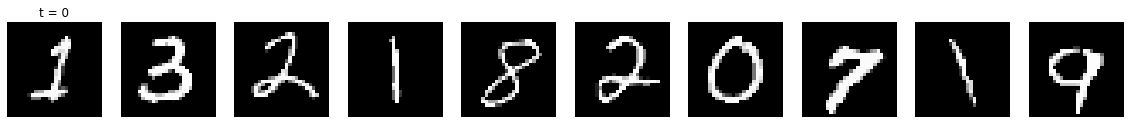

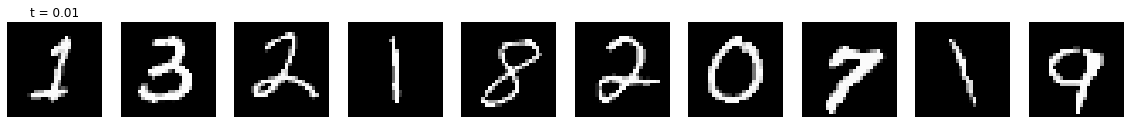

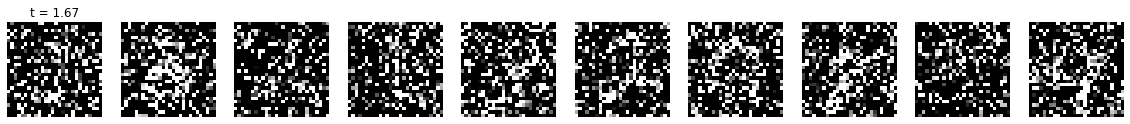

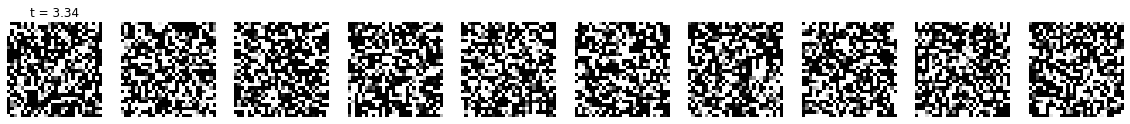

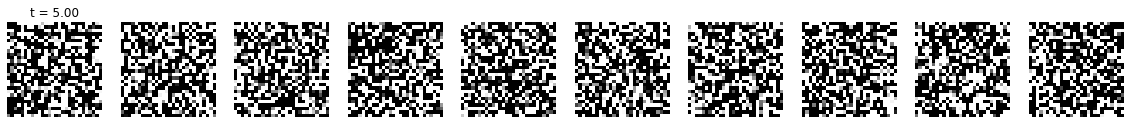

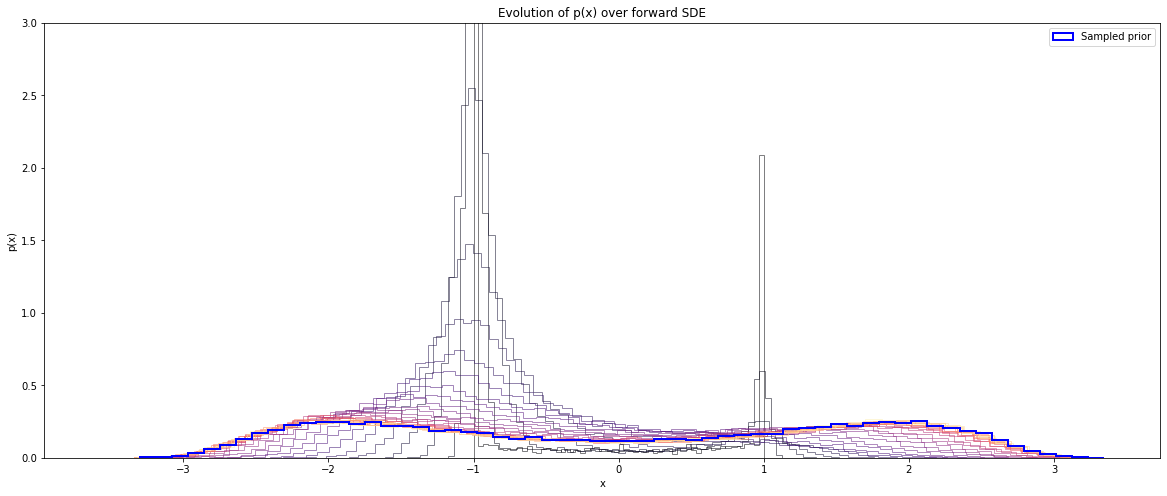

In [12]:
# Show some images after running the SDE forward for different times
time_steps = 4

x0, _ = next(iter(data_loader))

def plot_digits(x, num_to_plot=10, title=None):
    fig, ax = plt.subplots(ncols=num_to_plot, figsize=(20, 4))
    for i in range(num_to_plot):
        ax[i].imshow(x[i].permute(1, 2, 0), cmap="gray")
        ax[i].axis('off')
    if title:
        ax[0].set_title(title)
    plt.show()
    
plot_digits(np.clip(x0, 0, 1), title="t = 0")
x0 = x0.to(DEVICE)
for t in np.linspace(0.01, t_limit, time_steps):
    xt, score = sde.forward(x0, torch.full(x0.shape[:1], t).to(DEVICE))
    plot_digits(torch.clamp(xt, 0, 1).cpu(), title=("t = %.2f" % t))
    
# Show the transformation of the distribution of data to the prior distribution
time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

In [13]:
saved_vals = []
train_model(
    model, sde, data_loader, num_epochs=30, learning_rate=0.001,
    loss_weighting_type="norm", t_limit=t_limit
)

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1 average Loss: 239.23


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2 average Loss: 98.87


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3 average Loss: 71.98


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4 average Loss: 58.71


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5 average Loss: 53.68


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6 average Loss: 49.75


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7 average Loss: 47.16


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8 average Loss: 45.80


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9 average Loss: 43.53


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10 average Loss: 42.57


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 11 average Loss: 41.52


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 12 average Loss: 40.11


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 13 average Loss: 39.34


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 14 average Loss: 38.44


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 15 average Loss: 37.63


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 16 average Loss: 36.84


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 17 average Loss: 37.06


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 18 average Loss: 36.57


  0%|          | 0/1875 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
# save_path = "".join(str(sde)[:str(sde).index("SDE")].strip().split()).lower() + "_first_epoch_stats.npz"
# np.savez(
#     save_path,
#     times=np.concatenate([tup[0] for tup in saved_vals]),
#     true_scores=np.concatenate([tup[1] for tup in saved_vals]),
#     pred_scores=np.concatenate([tup[2] for tup in saved_vals])
# )

### Sample from the trained model

The three strategies for sampling from the trained model are:

1. Euler-Maruyama: We take the corresponding reverse SDE and step through it backwards through time
2. Predictor-Corrector: Like Euler-Maruyama, but in each step we also run a round of Langevin dynamics to better align the step with the score function
3. ODE: We take the corresponding ODE of the reverse SDE (which has the same transitional probabilities) and step through it backwards through time using an ODE solver

In [14]:
def generate_samples(
    model, sde, sampler="em", num_samples=64, num_steps=500, epsilon=0.001,
    t_limit=1
):
    """
    Generates samples from a trained score model and SDE. This first
    generates a sample from the SDE's prior distribution a t = 1, then
    steps backward through time to generate new data points.
    Arguments:
        `model`: a trained score model which takes in x, t and
            predicts score
        `sde`: an SDE object
        `sampler`: one of "em", "pc", or "ode" for Euler-Maruyama,
            predictor-corrector, or ordinary differential equation,
            respectively
        `num_samples`: number of objects to return
        `num_steps`: number of steps to take for Euler-Maruyama and
            predictor-corrector algorithms
        `epsilon`: last time step to stop at before hitting 0
        `t_limit`: the time step to start generating at
    Returns a tensor of size `num_samples` x ...
    """
    # First, sample from the prior distribution at some late time t
    t = (torch.ones(num_samples) * t_limit).to(DEVICE)
    xt = sde.sample_prior(num_samples, t)
    
    # Disable gradient computation in model
    torch.set_grad_enabled(False)
    
    if sampler == "em":
        # Euler-Maruyama
        time_steps = torch.linspace(t_limit, epsilon, num_steps).to(DEVICE)  # Descending order
        step_size = time_steps[0] - time_steps[1]
        
        # Step backward through time starting at xt, simulating the reverse SDE
        x = xt
        for time_step in tqdm.notebook.tqdm(time_steps):
            t = torch.ones(num_samples).to(DEVICE) * time_step
            f = sde.drift_coef_func(x, t)
            g = sde.diff_coef_func(x, t)
            dw = torch.randn_like(x)
            
            drift = (f - (torch.square(g) * model(x, t))) * step_size
            diff = g * torch.sqrt(step_size) * dw
            
            mean_x = x - drift  # Subtract here because step size is really negative
            x = mean_x + diff
        return mean_x  # In the last step, don't include the diffusion/randomized term
    
    elif sampler == "pc":
        # Predictor-Corrector
        time_steps = torch.linspace(t_limit, epsilon, num_steps).to(DEVICE)  # Descending order
        step_size = time_steps[0] - time_steps[1]
        
        # Step backward through time starting at xt
        x = xt
        for time_step in tqdm.notebook.tqdm(time_steps):
            t = torch.ones(num_samples).to(DEVICE) * time_step
            
            # Take Langevin MCMC step
            score = model(x, t)
            
            snr = 0.1
            score_norm = torch.mean(torch.norm(score.reshape(score.shape[0], -1), dim=-1))
            alpha = snr * (torch.prod(torch.tensor(x.shape[1:])) / torch.square(score_norm))
            
            x = x + ((alpha / 2) * score) + (torch.sqrt(alpha) * torch.randn_like(x))
            
            # Take SDE step
            f = sde.drift_coef_func(x, t)
            g = sde.diff_coef_func(x, t)
            dw = torch.randn_like(x)
            
            drift = (f - (torch.square(g) * model(x, t))) * step_size
            diff = g * torch.sqrt(step_size) * dw
            
            mean_x = x - drift  # Subtract here because step size is really negative
            x = mean_x + diff
            
        return mean_x  # In the last step, don't include the diffusion/randomized term
    
    elif sampler == "ode":
        # ODE
        t = torch.ones(num_samples).to(DEVICE)
        x_shape = tuple(torch.tensor(xt.shape).numpy())
        
        # Define function used by ODE solver:
        def ode_func(t, x):
            # t is a scalar; x is a 1D NumPy array
            x_tens = torch.tensor(x).float().to(DEVICE).view(x_shape)
            t_tens = torch.ones(num_samples).to(DEVICE) * t
            
            score_tens = model(x_tens, t_tens)
            f_tens = sde.drift_coef_func(x_tens, t_tens)
            g_tens = sde.diff_coef_func(x_tens, t_tens)
            
            step_tens = f_tens - (0.5 * torch.square(g_tens) * score_tens)
            return step_tens.reshape(-1).cpu().numpy().astype(np.float64)
        
        # Run the ODE solver
        result = scipy.integrate.solve_ivp(
            ode_func, (t_limit, epsilon),
            xt.reshape(-1).cpu().numpy(),
            rtol=0.00001, atol=0.00001,
            method="RK45"
        )
        print("Number of ODE function evaluations: %d" % result.nfev)
        return torch.tensor(result.y[:, -1]).to(DEVICE).reshape(x_shape)

In [15]:
weights = torch.load("ckpt.pth")
model.load_state_dict(weights)

<All keys matched successfully>

  0%|          | 0/500 [00:00<?, ?it/s]

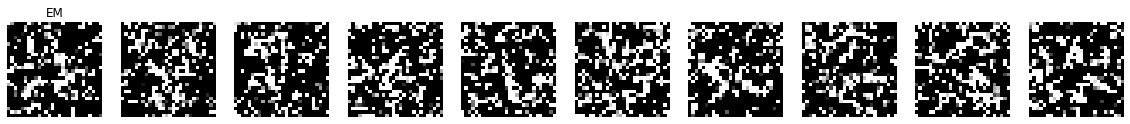

  0%|          | 0/500 [00:00<?, ?it/s]

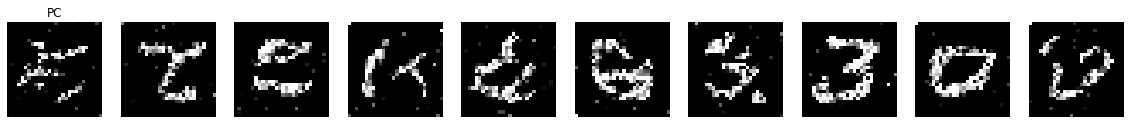

Number of ODE function evaluations: 224


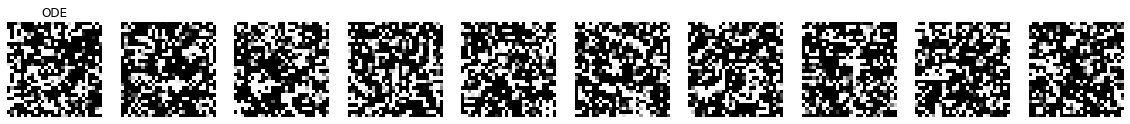

In [16]:
for sampler in ("em", "pc", "ode"):
    samples = generate_samples(model, sde, sampler=sampler, t_limit=1)
    plot_digits(torch.clamp(samples, 0, 1).cpu(), title=sampler.upper())